# BASALT 2022 Dataset Exploration (Self Generated Data)

## Background
I am working on potential solutions for https://www.aicrowd.com/challenges/neurips-2022-minerl-basalt-competition. This is a notebook for visualization/exploration of BASALT 2022 competition gameplay dataset. This one is fun because it has a lot of pictures and data preprocessing.

## Data Mining
In order to get the data for this, I loaded my agent with OpenAI's VPT Model and had it run around the gym environment.

## Code

### Imports

In [1]:
import pandas as pd
import numpy as np
import PIL.Image
import cv2
import json
import os
from IPython.display import Image 

### Functions

In [16]:
def getFrames(videoPath, startFrame, numFrames):
    cap = cv2.VideoCapture(videoPath)
    frameCount = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    cap.set(1,startFrame)
    frameWidth = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frameHeight = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

    buf = []

    fc = startFrame
    ret = True

    counter = numFrames-1
    while (fc < startFrame + numFrames):
        
        ret, frame = cap.read()
        buf.append(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
        fc += 1
        counter -= 1

    cap.release()
    return buf

### Read in Data

In [3]:
challenges = ["MineRLBasaltBuildVillageHouse-v0", "MineRLBasaltCreateVillageAnimalPen-v0", "MineRLBasaltFindCave-v0", "MineRLBasaltMakeWaterfall-v0"]
movesPath = "../assets/datasets/BASALT Contractor Dataset/"

allMoves = []
for challenge in challenges:
    for file in os.listdir(movesPath + challenge + "/"):
        if ".jsonl" in file:
            stamp = file.split(".")[0]
            videoFile = stamp + ".mp4"
            df = pd.read_json(path_or_buf=movesPath + challenge + "/" + file, lines=True)
            df["videoFile"] = movesPath + challenge + "/" + videoFile
            allMoves.append(df)
moves = pd.concat(allMoves)
moves.head(5)

,mouse,keyboard,hotbar,tick,isGuiOpen,videoFile
0,"{'x': 640.0, 'y': 360.0, 'dx': 0.0, 'dy': 0.0,...","{'keys': ['key.keyboard.left.control', 'key.ke...",0,0,False,../assets/datasets/BASALT Contractor Dataset/M...
1,"{'x': 640.0, 'y': 360.0, 'dx': 0.0, 'dy': 0.0,...","{'keys': [], 'newKeys': [], 'chars': ''}",0,1,False,../assets/datasets/BASALT Contractor Dataset/M...
2,"{'x': 640.0, 'y': 360.0, 'dx': 0.0, 'dy': 0.0,...","{'keys': [], 'newKeys': [], 'chars': ''}",0,2,False,../assets/datasets/BASALT Contractor Dataset/M...
3,"{'x': 640.0, 'y': 360.0, 'dx': 0.0, 'dy': 0.0,...","{'keys': [], 'newKeys': [], 'chars': ''}",0,3,False,../assets/datasets/BASALT Contractor Dataset/M...
4,"{'x': 640.0, 'y': 360.0, 'dx': 0.0, 'dy': 0.0,...","{'keys': [], 'newKeys': [], 'chars': ''}",0,4,False,../assets/datasets/BASALT Contractor Dataset/M...


In [4]:
mouseData = {}
keyboardData = {}

for index, row in moves.iterrows():
    mouseDict = json.loads(str(row['mouse']).replace("'", '"'))
    for key in mouseDict:
        if key in mouseData.keys():
            mouseData[key].append(mouseDict[key])
        else:
            mouseData.update({key: [mouseDict[key]]})
    
    keyboardDict = json.loads(str(row['keyboard']).replace("'", '"'))
    for key in keyboardDict:
        if key in keyboardData.keys():
            keyboardData[key].append(keyboardDict[key])
        else:
            keyboardData.update({key: [keyboardDict[key]]})
        
    
            
for key in mouseData.keys():
    moves["mouse_" + str(key)] = mouseData[key]
for key in keyboardData.keys():
    moves["kb_" + str(key)] = keyboardData[key]
moves = moves.drop(["keyboard", "mouse"], axis=1)
moves.head(5)

,hotbar,tick,isGuiOpen,videoFile,mouse_x,mouse_y,mouse_dx,mouse_dy,mouse_scaledX,mouse_scaledY,mouse_dwheel,mouse_buttons,mouse_newButtons,kb_keys,kb_newKeys,kb_chars
0,0,0,False,../assets/datasets/BASALT Contractor Dataset/M...,640.0,360.0,0.0,0.0,0.0,0.0,0.0,[0],[0],"[key.keyboard.left.control, key.keyboard.left....","[key.keyboard.left.control, key.keyboard.left....",
1,0,1,False,../assets/datasets/BASALT Contractor Dataset/M...,640.0,360.0,0.0,0.0,0.0,0.0,0.0,[0],[],[],[],
2,0,2,False,../assets/datasets/BASALT Contractor Dataset/M...,640.0,360.0,0.0,0.0,0.0,0.0,0.0,[0],[],[],[],
3,0,3,False,../assets/datasets/BASALT Contractor Dataset/M...,640.0,360.0,0.0,0.0,0.0,0.0,0.0,[0],[],[],[],
4,0,4,False,../assets/datasets/BASALT Contractor Dataset/M...,640.0,360.0,0.0,0.0,0.0,0.0,0.0,[0],[],[],[],


In [5]:
buttonData = {"attack": [], "use": [], "pickItem": []}
for index, row in moves.iterrows():
    mouseBtnList = str(row['mouse_buttons'])
    
    if row['tick'] == 0:
        # Check if attack will be stuck down
        if str(row['mouse_newButtons']) == "[0]":
            attack_is_stuck = True
    elif attack_is_stuck:
        # Check if we press attack down, then it might not be stuck
        if '0' in str(row['mouse_newButtons']):
            attack_is_stuck = False
    # If still stuck, remove the action
    if attack_is_stuck:
        mouseBtnList = mouseBtnList.replace('0', '')
    
    if '0' in mouseBtnList:
        buttonData['attack'].append(1)
    else:
        buttonData['attack'].append(0)
    
    if '1' in mouseBtnList:
        buttonData['use'].append(1)
    else:
        buttonData['use'].append(0)
    
    if '2' in mouseBtnList:
        buttonData['pickItem'].append(1)
    else:
        buttonData['pickItem'].append(0)
    if '3' in mouseBtnList:
        print(mouseBtnList)
    
for key in buttonData.keys():
    moves[key] = buttonData[key]
moves = moves.drop(["mouse_buttons", "mouse_newButtons", "kb_chars"], axis=1)
moves[moves["pickItem"]==1].head(50)

,hotbar,tick,isGuiOpen,videoFile,mouse_x,mouse_y,mouse_dx,mouse_dy,mouse_scaledX,mouse_scaledY,mouse_dwheel,kb_keys,kb_newKeys,attack,use,pickItem
595,3,595,False,../assets/datasets/BASALT Contractor Dataset/M...,2005.0,399.0,0.0,0.0,1365.0,39.0,0.0,[key.keyboard.w],[key.keyboard.w],0,0,1
596,3,596,False,../assets/datasets/BASALT Contractor Dataset/M...,2005.0,399.0,0.0,0.0,1365.0,39.0,0.0,[],[],0,0,1
597,3,597,False,../assets/datasets/BASALT Contractor Dataset/M...,2005.0,399.0,0.0,0.0,1365.0,39.0,0.0,[],[],0,0,1
598,3,598,False,../assets/datasets/BASALT Contractor Dataset/M...,2005.0,399.0,0.0,0.0,1365.0,39.0,0.0,[key.keyboard.s],[key.keyboard.s],0,0,1
59,0,59,False,../assets/datasets/BASALT Contractor Dataset/M...,843.0,256.0,0.0,0.0,203.0,-104.0,0.0,[],[],0,0,1
60,0,60,False,../assets/datasets/BASALT Contractor Dataset/M...,843.0,256.0,0.0,0.0,203.0,-104.0,0.0,[],[],0,0,1
61,0,61,False,../assets/datasets/BASALT Contractor Dataset/M...,843.0,256.0,0.0,0.0,203.0,-104.0,0.0,[],[],0,0,1
97,0,97,False,../assets/datasets/BASALT Contractor Dataset/M...,1046.0,382.0,0.0,0.0,406.0,22.0,0.0,[],[],0,0,1
98,0,98,False,../assets/datasets/BASALT Contractor Dataset/M...,1046.0,382.0,0.0,0.0,406.0,22.0,0.0,[],[],0,0,1
99,0,99,False,../assets/datasets/BASALT Contractor Dataset/M...,1046.0,382.0,-3.0,0.0,406.0,22.0,0.0,[],[],0,0,1


In [6]:
KEYBOARD_BUTTON_MAPPING = {
    "key.keyboard.escape" :"ESC",
    "key.keyboard.s" :"back",
    "key.keyboard.q" :"drop",
    "key.keyboard.w" :"forward",
    "key.keyboard.1" :"hotbar.1",
    "key.keyboard.2" :"hotbar.2",
    "key.keyboard.3" :"hotbar.3",
    "key.keyboard.4" :"hotbar.4",
    "key.keyboard.5" :"hotbar.5",
    "key.keyboard.6" :"hotbar.6",
    "key.keyboard.7" :"hotbar.7",
    "key.keyboard.8" :"hotbar.8",
    "key.keyboard.9" :"hotbar.9",
    "key.keyboard.e" :"inventory",
    "key.keyboard.space" :"jump",
    "key.keyboard.a" :"left",
    "key.keyboard.d" :"right",
    "key.keyboard.left.shift" :"sneak",
    "key.keyboard.left.control" :"sprint",
    "key.keyboard.f" :"swapHands",
}

buttonData = {}
[buttonData.update({KEYBOARD_BUTTON_MAPPING[key]: []}) for key in KEYBOARD_BUTTON_MAPPING.keys()]

for index, row in moves.iterrows():
    kbBtnList = str(row['kb_keys'])
    for key in KEYBOARD_BUTTON_MAPPING.keys():
        if key in kbBtnList:
            buttonData[KEYBOARD_BUTTON_MAPPING[key]].append(1)
        else:
            buttonData[KEYBOARD_BUTTON_MAPPING[key]].append(0)
    
for key in buttonData.keys():
    moves[key] = buttonData[key]
moves = moves.drop(["kb_keys", "kb_newKeys"], axis=1)
moves.head(50)

,hotbar,tick,isGuiOpen,videoFile,mouse_x,mouse_y,mouse_dx,mouse_dy,mouse_scaledX,mouse_scaledY,...,hotbar.7,hotbar.8,hotbar.9,inventory,jump,left,right,sneak,sprint,swapHands
0,0,0,False,../assets/datasets/BASALT Contractor Dataset/M...,640.0,360.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,1,0
1,0,1,False,../assets/datasets/BASALT Contractor Dataset/M...,640.0,360.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
2,0,2,False,../assets/datasets/BASALT Contractor Dataset/M...,640.0,360.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
3,0,3,False,../assets/datasets/BASALT Contractor Dataset/M...,640.0,360.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
4,0,4,False,../assets/datasets/BASALT Contractor Dataset/M...,640.0,360.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
5,0,5,False,../assets/datasets/BASALT Contractor Dataset/M...,640.0,360.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
6,0,6,False,../assets/datasets/BASALT Contractor Dataset/M...,640.0,360.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
7,0,7,False,../assets/datasets/BASALT Contractor Dataset/M...,640.0,360.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
8,0,8,False,../assets/datasets/BASALT Contractor Dataset/M...,640.0,360.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
9,0,9,False,../assets/datasets/BASALT Contractor Dataset/M...,640.0,360.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
moves["isGuiOpen"] = np.where(moves["isGuiOpen"]==True, 1, 0)
moves.head(50)

,hotbar,tick,isGuiOpen,videoFile,mouse_x,mouse_y,mouse_dx,mouse_dy,mouse_scaledX,mouse_scaledY,...,hotbar.7,hotbar.8,hotbar.9,inventory,jump,left,right,sneak,sprint,swapHands
0,0,0,0,../assets/datasets/BASALT Contractor Dataset/M...,640.0,360.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,1,0
1,0,1,0,../assets/datasets/BASALT Contractor Dataset/M...,640.0,360.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
2,0,2,0,../assets/datasets/BASALT Contractor Dataset/M...,640.0,360.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
3,0,3,0,../assets/datasets/BASALT Contractor Dataset/M...,640.0,360.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
4,0,4,0,../assets/datasets/BASALT Contractor Dataset/M...,640.0,360.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
5,0,5,0,../assets/datasets/BASALT Contractor Dataset/M...,640.0,360.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
6,0,6,0,../assets/datasets/BASALT Contractor Dataset/M...,640.0,360.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
7,0,7,0,../assets/datasets/BASALT Contractor Dataset/M...,640.0,360.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
8,0,8,0,../assets/datasets/BASALT Contractor Dataset/M...,640.0,360.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
9,0,9,0,../assets/datasets/BASALT Contractor Dataset/M...,640.0,360.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0


In [8]:
print(len(moves["isGuiOpen"]))

251016


hotbar = 2
tick = 1241
isGuiOpen = 0
videoFile = ../assets/datasets/BASALT Contractor Dataset/MineRLBasaltBuildVillageHouse-v0/Player658-a6c3c32a889a-20220708-120757.mp4
mouse_x = 2454.0
mouse_y = 882.0
mouse_dx = 0.0
mouse_dy = -4.0
mouse_scaledX = 1814.0
mouse_scaledY = 522.0
mouse_dwheel = 0.0
attack = 0
use = 1
pickItem = 0
ESC = 0
back = 0
drop = 0
forward = 1
hotbar.1 = 0
hotbar.2 = 0
hotbar.3 = 0
hotbar.4 = 0
hotbar.5 = 0
hotbar.6 = 0
hotbar.7 = 0
hotbar.8 = 0
hotbar.9 = 0
inventory = 0
jump = 0
left = 0
right = 0
sneak = 0
sprint = 0
swapHands = 0


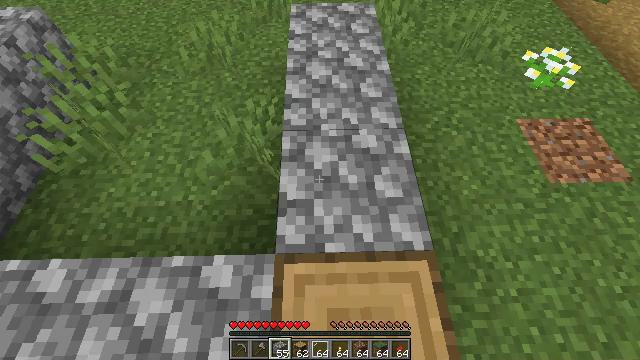

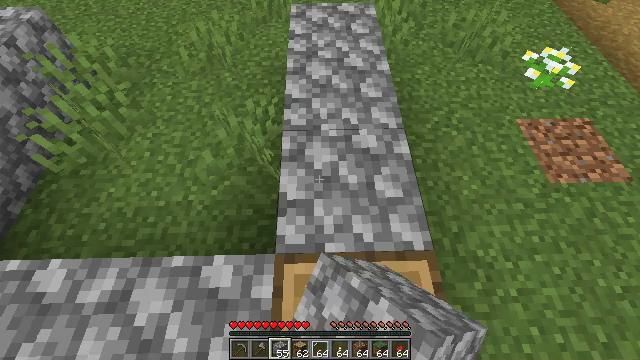

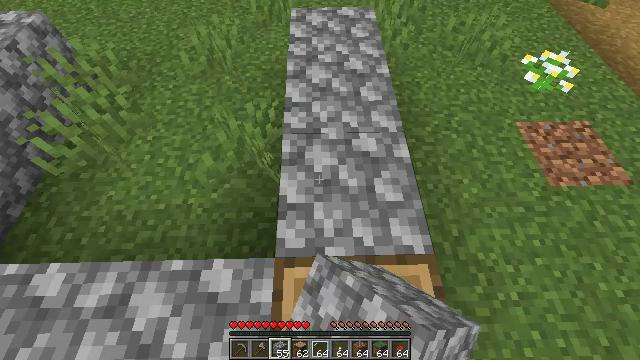

hotbar = 3
tick = 4055
isGuiOpen = 0
videoFile = ../assets/datasets/BASALT Contractor Dataset/MineRLBasaltBuildVillageHouse-v0/Player658-ef4293114019-20220708-121505.mp4
mouse_x = 881.0
mouse_y = 257.0
mouse_dx = 0.0
mouse_dy = 0.0
mouse_scaledX = 241.0
mouse_scaledY = -103.0
mouse_dwheel = 0.0
attack = 0
use = 1
pickItem = 0
ESC = 0
back = 0
drop = 0
forward = 0
hotbar.1 = 0
hotbar.2 = 0
hotbar.3 = 0
hotbar.4 = 0
hotbar.5 = 0
hotbar.6 = 0
hotbar.7 = 0
hotbar.8 = 0
hotbar.9 = 0
inventory = 0
jump = 0
left = 0
right = 0
sneak = 1
sprint = 0
swapHands = 0


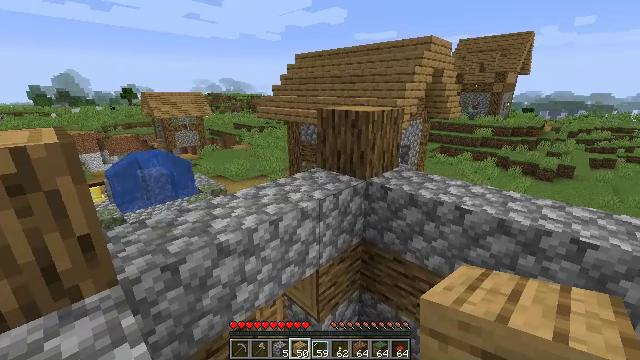

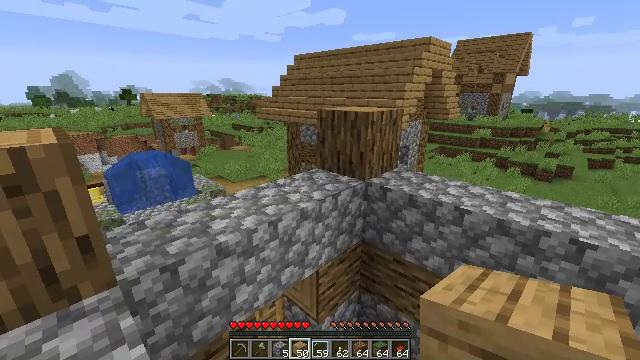

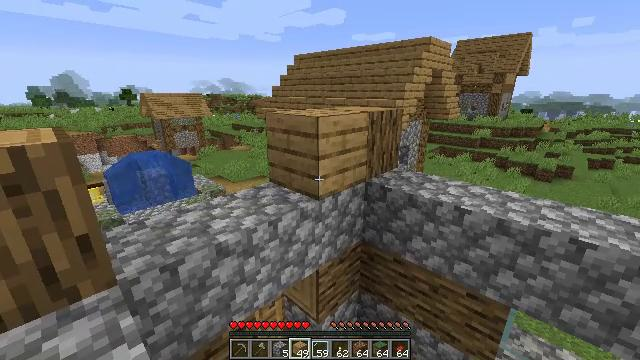

hotbar = 2
tick = 2511
isGuiOpen = 0
videoFile = ../assets/datasets/BASALT Contractor Dataset/MineRLBasaltBuildVillageHouse-v0/Player281-83820970e03a-20220706-205820.mp4
mouse_x = 5368.0
mouse_y = 997.0
mouse_dx = 10.0
mouse_dy = 7.0
mouse_scaledX = 4728.0
mouse_scaledY = 637.0
mouse_dwheel = 0.0
attack = 0
use = 1
pickItem = 0
ESC = 0
back = 0
drop = 0
forward = 0
hotbar.1 = 0
hotbar.2 = 0
hotbar.3 = 0
hotbar.4 = 0
hotbar.5 = 0
hotbar.6 = 0
hotbar.7 = 0
hotbar.8 = 0
hotbar.9 = 0
inventory = 0
jump = 0
left = 0
right = 0
sneak = 0
sprint = 0
swapHands = 0


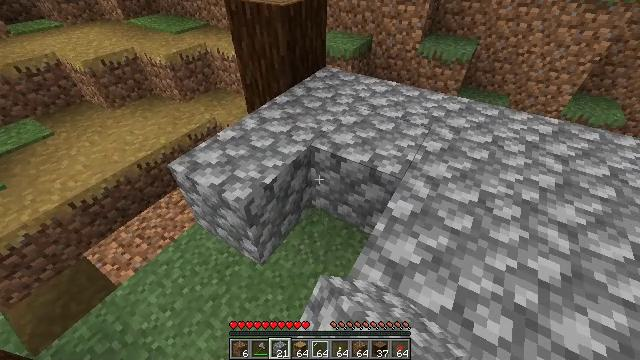

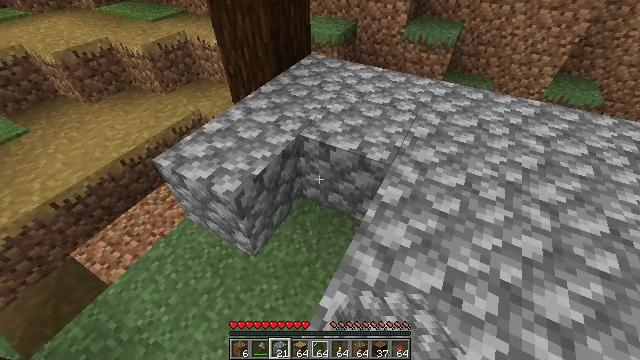

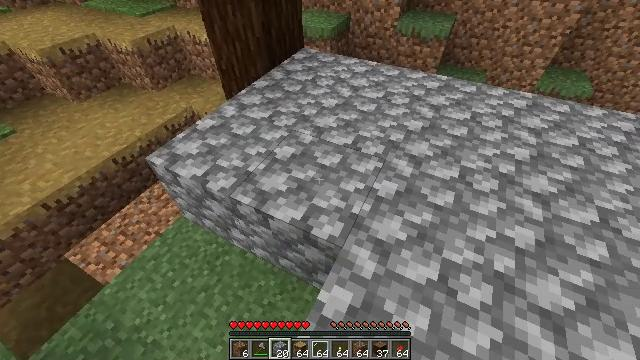

hotbar = 0
tick = 3148
isGuiOpen = 0
videoFile = ../assets/datasets/BASALT Contractor Dataset/MineRLBasaltBuildVillageHouse-v0/Player281-b7609a041eb8-20220706-212257.mp4
mouse_x = -1620.0
mouse_y = 312.0
mouse_dx = 0.0
mouse_dy = 0.0
mouse_scaledX = -2260.0
mouse_scaledY = -48.0
mouse_dwheel = 0.0
attack = 0
use = 1
pickItem = 0
ESC = 0
back = 0
drop = 0
forward = 0
hotbar.1 = 0
hotbar.2 = 0
hotbar.3 = 0
hotbar.4 = 0
hotbar.5 = 0
hotbar.6 = 0
hotbar.7 = 0
hotbar.8 = 0
hotbar.9 = 0
inventory = 0
jump = 0
left = 0
right = 0
sneak = 0
sprint = 0
swapHands = 0


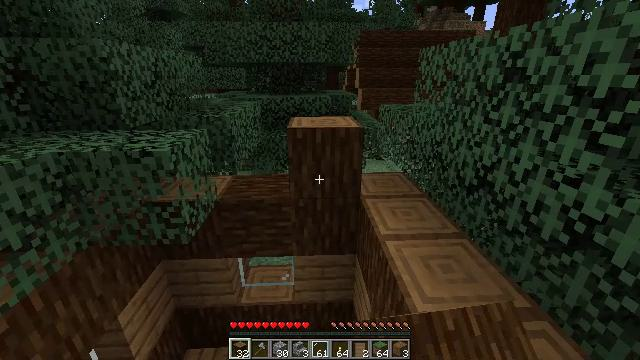

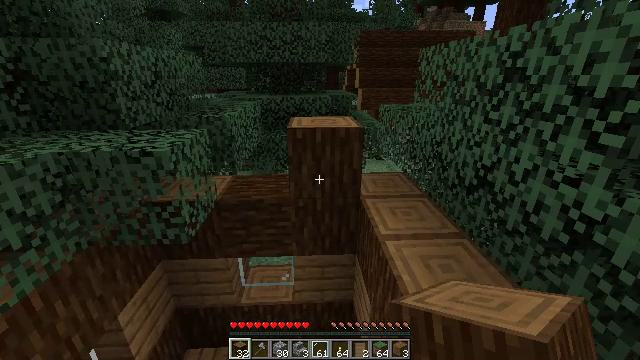

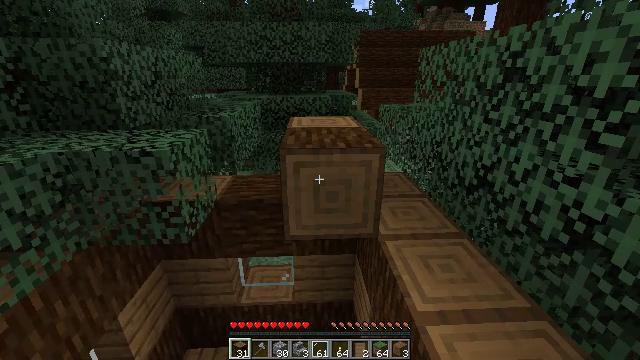

hotbar = 2
tick = 371
isGuiOpen = 0
videoFile = ../assets/datasets/BASALT Contractor Dataset/MineRLBasaltBuildVillageHouse-v0/Player658-ef4293114019-20220708-121505.mp4
mouse_x = 3042.0
mouse_y = 508.0
mouse_dx = 0.0
mouse_dy = 0.0
mouse_scaledX = 2402.0
mouse_scaledY = 148.0
mouse_dwheel = 0.0
attack = 0
use = 1
pickItem = 0
ESC = 0
back = 0
drop = 0
forward = 0
hotbar.1 = 0
hotbar.2 = 0
hotbar.3 = 0
hotbar.4 = 0
hotbar.5 = 0
hotbar.6 = 0
hotbar.7 = 0
hotbar.8 = 0
hotbar.9 = 0
inventory = 0
jump = 0
left = 0
right = 0
sneak = 0
sprint = 0
swapHands = 0


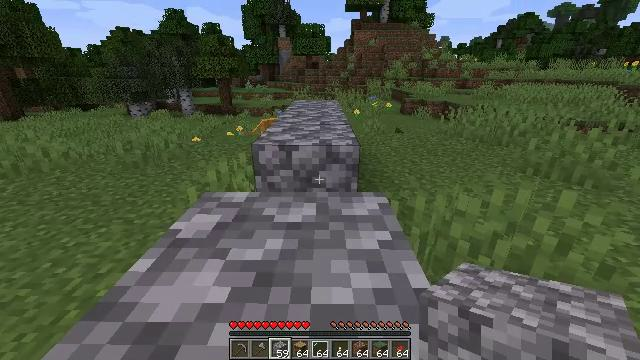

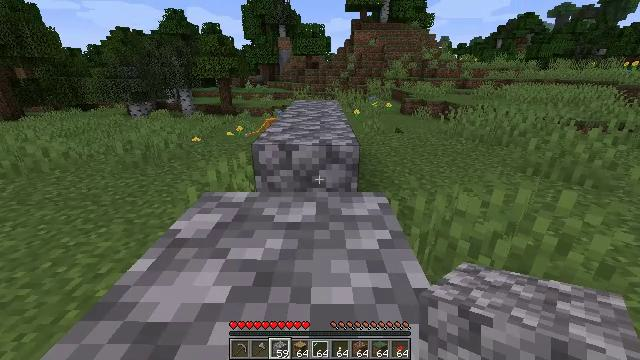

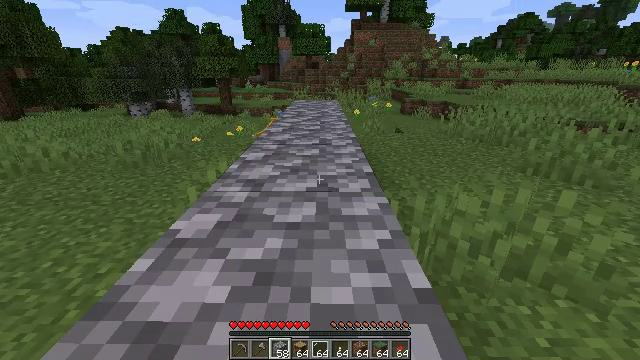

In [17]:
invOpen = moves[moves["isGuiOpen"]==0]
sample = invOpen[invOpen["use"]==1].sample(5)
for index, row in sample.iterrows():
    for key in row.keys():
        print(key, "=", row[key])
    frames = getFrames(row['videoFile'], row['tick']-1, 3)
    for frame in frames:
        PIL.Image.fromarray(frame).save("image.jpg")
        display(Image(filename="image.jpg"))

In [ ]:
moves.to_csv(movesPath + "/moves.csv", index=False)

In [ ]:
openedMoves = pd.read_csv(movesPath + "/moves.csv")
openedMoves.head()